In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
training_data = datasets.MNIST(
    "data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    "data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

train_data_loader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)
test_data_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
)

for X, y in train_data_loader:
    print(X.shape)
    print(y.shape)
    break

for X, y in test_data_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [17]:
class NeualNetwork(nn.Module):
    def __init__(self):
        super(NeualNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(5 * 5 * 64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        output = self.model(x)
        return output


In [18]:
device = (
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)

model = NeualNetwork().to(device)

In [19]:
print(model)

NeualNetwork(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1600, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [20]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    correct, test_loss = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # move to device
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        test_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    test_loss /= len(dataloader)
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [21]:
def test(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)

    with torch.no_grad():
        test_loss, correct = 0, 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) # move to device
            pred = model(X)
            loss = loss_fn(pred, y)

            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        test_loss /= num_batches
        correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train(train_data_loader, model, loss_fn, optimizer)
    test(test_data_loader, model, loss_fn)

print("finish training")

Epoch 1/5
loss: 2.417009  [    0/60000]
loss: 0.195238  [ 6400/60000]
loss: 0.065534  [12800/60000]
loss: 0.038239  [19200/60000]
loss: 0.040706  [25600/60000]
loss: 0.110030  [32000/60000]
loss: 0.011749  [38400/60000]
loss: 0.030048  [44800/60000]
loss: 0.025305  [51200/60000]
loss: 0.062071  [57600/60000]
Train Error: 
 Accuracy: 97.2%, Avg loss: 0.118870 

Test Error: 
 Accuracy: 98.8%, Avg loss: 0.039771 

Epoch 2/5
loss: 0.007218  [    0/60000]
loss: 0.031424  [ 6400/60000]
loss: 0.033145  [12800/60000]
loss: 0.014479  [19200/60000]
loss: 0.045510  [25600/60000]
loss: 0.011145  [32000/60000]
loss: 0.009692  [38400/60000]
loss: 0.055103  [44800/60000]
loss: 0.113629  [51200/60000]
loss: 0.010757  [57600/60000]
Train Error: 
 Accuracy: 98.7%, Avg loss: 0.043703 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.032147 

Epoch 3/5
loss: 0.009175  [    0/60000]
loss: 0.004185  [ 6400/60000]
loss: 0.031055  [12800/60000]
loss: 0.021883  [19200/60000]
loss: 0.279238  [25600/60000]
loss: 0.00

In [10]:
torch.save(
    model.state_dict(),
    "model_weight.pth",
)

print("Saved pytorch model weight")

Saved pytorch model weight


In [11]:
model_2 = NeualNetwork().to(device)

model_2.load_state_dict(
    torch.load(
        "model_weight.pth",
        weights_only=True,
    )
)

<All keys matched successfully>

In [ ]:
model_2.eval()
# 第一张图片
X, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
    X = X.to(device)
    pred = model_2(X)
    predicted, actual = pred[0].argmax(0), y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7", Actual: "7"


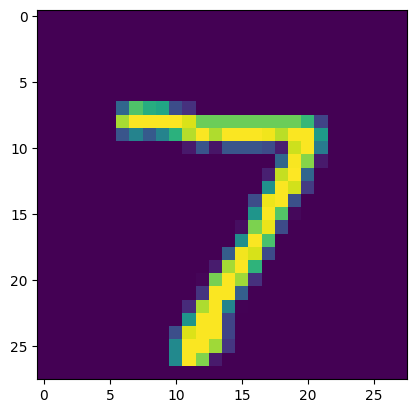

In [15]:
import matplotlib.pyplot as plt

plt.imshow(X.cpu().numpy().squeeze())
plt.show()